In [1]:
import sqlite3 as sql
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
import joblib
from sklearn.pipeline import Pipeline



pd.set_option('display.max_columns', 30)
con = sql.connect("customers.db")


query = """
SELECT *
FROM sqlite_master
WHERE type='table';
"""
pd.read_sql_query(query, con)

,type,name,tbl_name,rootpage,sql
0,table,Applications,Applications,2,CREATE TABLE Applications(\n app_id INTEGER...
1,table,CreditBureau,CreditBureau,8,CREATE TABLE CreditBureau(\n ssn INTEGE...
2,table,Demographic,Demographic,25,CREATE TABLE Demographic(\n zip...


In [2]:
query1 = """
SELECT *
FROM Applications;"""
pd.read_sql_query(query1,con)

,app_id,ssn,zip_code,income,homeownership,purchases,credit_limit
0,102227,123817237,49020,47000.0,Rent,3097.157200,3100.0
1,109792,589049197,61116,71000.0,Own,13689.566804,24300.0
2,110171,322099062,77562,38000.0,Rent,6774.730206,15200.0
3,113087,848114225,15985,68000.0,Rent,8895.214327,25200.0
4,116110,946986483,73654,58000.0,Own,12339.389402,35900.0
...,...,...,...,...,...,...,...
495,996616,353991153,51921,31000.0,Own,11687.598108,13200.0
496,997389,666988048,15509,99000.0,Own,9282.163370,31100.0
497,997614,557171452,16505,86000.0,Rent,6465.586439,35500.0
498,997987,794496014,82585,87000.0,Own,5861.435320,16400.0


In [3]:
purchase_app = pd.read_sql("""SELECT * FROM Applications;""",con)
purchase_app.head()

print(f' Null Values from Purcase App df: {purchase_app.isnull().sum()}')
print(f'dtypes from Purchase APP df: {purchase_app.dtypes}')
print(f'nunique from Purchase App df: {purchase_app.nunique()}')
print(f'Duplicated Values from Purchase App: {purchase_app.duplicated().sum()}')


 Null Values from Purcase App df: app_id           0
ssn              0
zip_code         0
income           0
homeownership    0
purchases        0
credit_limit     0
dtype: int64
dtypes from Purchase APP df: app_id             int64
ssn                int64
zip_code           int64
income           float64
homeownership     object
purchases        float64
credit_limit     float64
dtype: object
nunique from Purchase App df: app_id           500
ssn              500
zip_code         500
income           106
homeownership      2
purchases        500
credit_limit     257
dtype: int64
Duplicated Values from Purchase App: 0


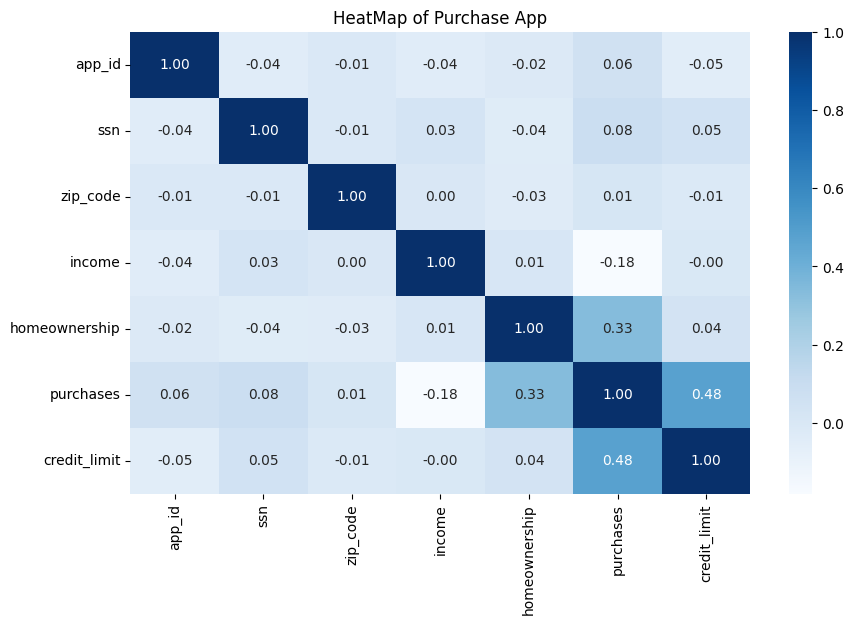

In [4]:

purchase_app['homeownership'] = purchase_app['homeownership'].map({"Rent":0,"Own":1})



plt.figure(figsize=(10,6))
sns.heatmap(purchase_app.corr(),annot=True,fmt=".2f",cmap="Blues")
plt.title("HeatMap of Purchase App")
plt.savefig("images/purchase-app_confusion-matrix.png")
plt.show()

C:\Users\katsa\AppData\Local\Temp\ipykernel_21676\1710340639.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


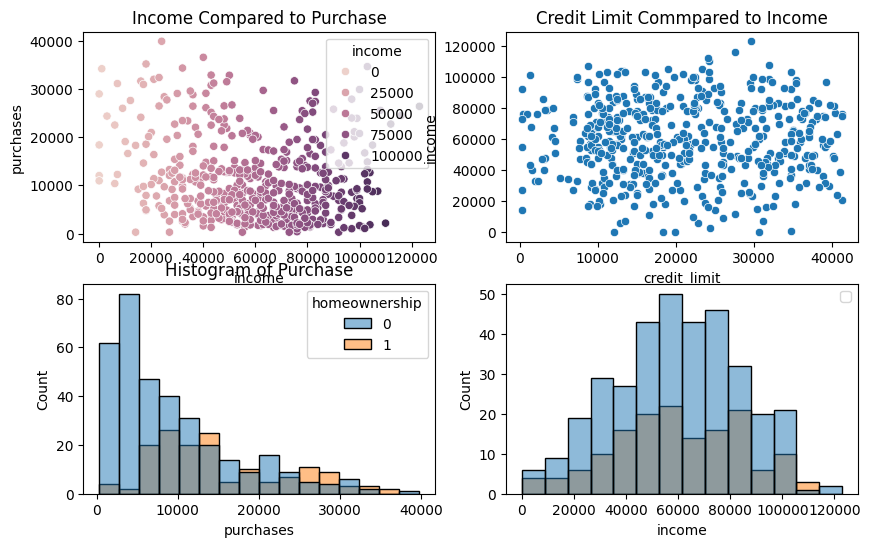

In [5]:
fig,axs = plt.subplots(2,2,figsize=(10,6))
sns.scatterplot(x='income',y='purchases',hue="income",ax=axs[0,0],data=purchase_app)
axs[0,0].set_title("Income Compared to Purchase")
sns.scatterplot(x='credit_limit',y='income',ax=axs[0,1],data=purchase_app)
axs[0,1].set_title("Credit Limit Commpared to Income")
sns.histplot(x='purchases',hue='homeownership',ax=axs[1,0],data=purchase_app)
axs[1,0].set_title("Histogram of Purchase")
sns.histplot(x='income',hue='homeownership',data=purchase_app)
plt.legend()
plt.savefig("images/desc_stats1.png")
plt.show()

In [6]:
X0 = purchase_app.drop(['app_id','ssn','zip_code','purchases'],axis=1)
y0 = purchase_app['purchases']

model1 = sm.OLS(exog=sm.add_constant(X0), endog=y0).fit()
print(f'Results from Anova Table: {model1.summary()}')

Results from Anova Table:                             OLS Regression Results                            
Dep. Variable:              purchases   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     93.44
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           6.03e-48
Time:                        15:03:46   Log-Likelihood:                -5110.4
No. Observations:                 500   AIC:                         1.023e+04
Df Residuals:                     496   BIC:                         1.025e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5268.

In [7]:
purch_app_bureau = pd.read_sql(
    """
    SELECT a.*,c.*
    FROM Applications a
    JOIN CreditBureau c on a.zip_code = c.zip_code;""",con)


print(f'Null Values From purch_app_bureau: {purch_app_bureau.isnull().sum()}')
print(f'Duplicated Values From purch_app_bureau: {purch_app_bureau.duplicated().sum()}')
print(f'dtypes from purch_app_bureau: {purch_app_bureau.dtypes}')
print(f'Unique Values from purch_app_bureau: {purch_app_bureau.nunique()}')
print(f'Description of the Values in purch_app_bureau: {purch_app_bureau.describe()}')

Null Values From purch_app_bureau: app_id            0
ssn               0
zip_code          0
income            0
homeownership     0
purchases         0
credit_limit      0
ssn               0
zip_code          0
fico              0
num_late          0
past_def          0
num_bankruptcy    0
dtype: int64
Duplicated Values From purch_app_bureau: 0
dtypes from purch_app_bureau: app_id              int64
ssn                 int64
zip_code            int64
income            float64
homeownership      object
purchases         float64
credit_limit      float64
ssn                 int64
zip_code            int64
fico              float64
num_late            int64
past_def            int64
num_bankruptcy      int64
dtype: object
Unique Values from purch_app_bureau: app_id            500
ssn               500
zip_code          500
income            106
homeownership       2
purchases         500
credit_limit      257
ssn               500
zip_code          500
fico              282
num_late  

C:\Users\katsa\AppData\Local\Temp\ipykernel_21676\1084681610.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=purch_app_bureau,ax=axs[0,0],x='purchases',hue='past_def')


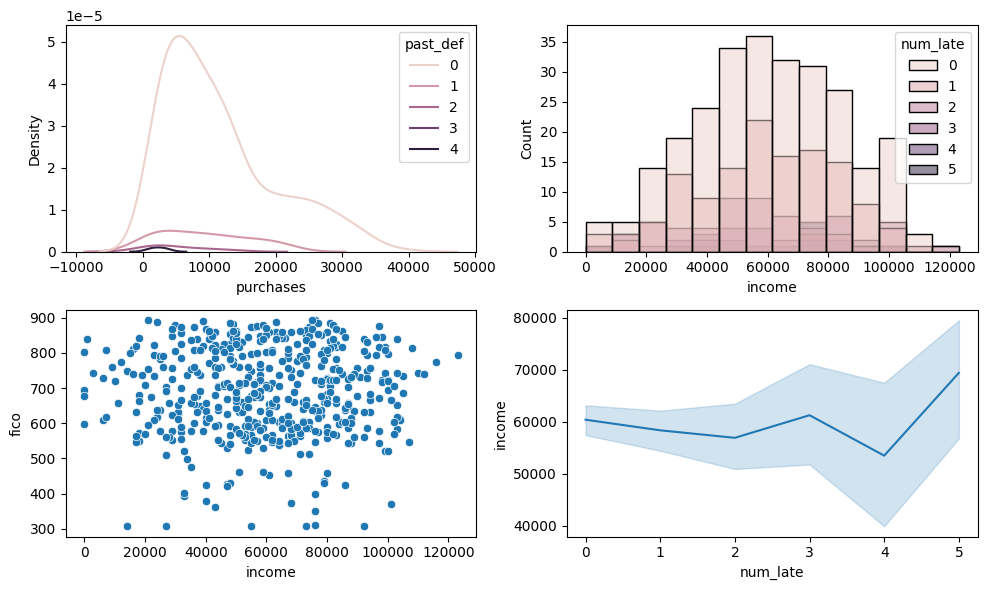

In [8]:
fig,axs = plt.subplots(2,2,figsize=(10,6))
sns.kdeplot(data=purch_app_bureau,ax=axs[0,0],x='purchases',hue='past_def')
sns.histplot(data=purch_app_bureau,ax=axs[0,1],x='income',hue='num_late')
sns.scatterplot(data=purch_app_bureau,ax=axs[1,0],x='income',y='fico')
sns.lineplot(data=purch_app_bureau,ax=axs[1,1],x='num_late',y='income')
plt.tight_layout()
plt.savefig("images/desc-stats2.png")
plt.show()

In [9]:
purch_app_bureau['homeownership'] = purch_app_bureau['homeownership'].map({"Rent":0,"Own":1})
X1 = purch_app_bureau.drop(['ssn','app_id','purchases','zip_code'], axis=1)
y1 = purch_app_bureau['purchases']

model2 = sm.OLS(exog=sm.add_constant(X1), endog=y1).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:              purchases   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     78.78
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           2.84e-76
Time:                        15:03:54   Log-Likelihood:                -5034.4
No. Observations:                 500   AIC:                         1.008e+04
Df Residuals:                     492   BIC:                         1.012e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -4.13e+04   6880.309     -6.

In [10]:

purchase_full = pd.read_sql("""
SELECT 
    a.*, 
    c.*, 
    d.*
FROM Applications a
JOIN CreditBureau c ON a.zip_code = c.zip_code
JOIN Demographic d ON a.zip_code = d.zip_code;
""", con)

purchase_full = purchase_full.loc[:,~purchase_full.columns.duplicated()].copy()
print(f'Null Values From Purchase Full: {purchase_full.isnull().sum()}')
print(f'Duplicated Values From Purchase Full: {purchase_full.duplicated().sum()}')
print(f'dtypes from Purchase full: {purchase_full.dtypes}')
print(f'Unique Values from Purchase Full: {purchase_full.nunique()}')
print(f'Description of the Values in Purchase Full: {purchase_full.describe()}')


Null Values From Purchase Full: app_id            0
ssn               0
zip_code          0
income            0
homeownership     0
purchases         0
credit_limit      0
fico              0
num_late          0
past_def          0
num_bankruptcy    0
avg_income        0
density           0
dtype: int64
Duplicated Values From Purchase Full: 0
dtypes from Purchase full: app_id              int64
ssn                 int64
zip_code            int64
income            float64
homeownership      object
purchases         float64
credit_limit      float64
fico              float64
num_late            int64
past_def            int64
num_bankruptcy      int64
avg_income        float64
density           float64
dtype: object
Unique Values from Purchase Full: app_id            500
ssn               500
zip_code          500
income            106
homeownership       2
purchases         500
credit_limit      257
fico              282
num_late            6
past_def            5
num_bankruptcy      4


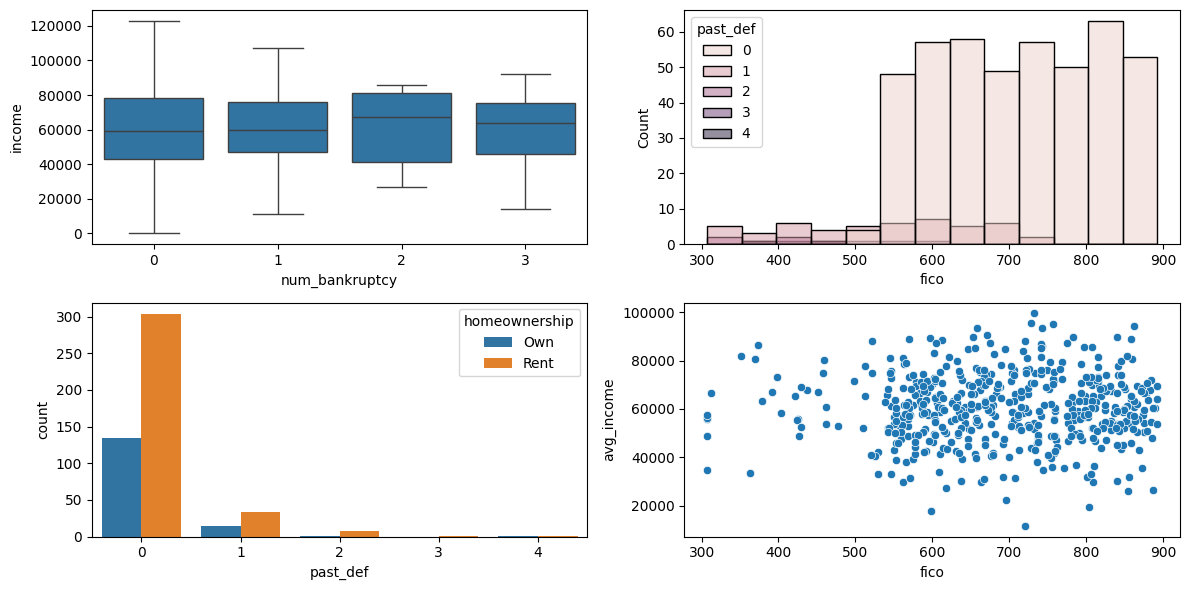

In [11]:
con.close()





fig,axs = plt.subplots(2,2,figsize=(12,6))
sns.boxplot(data=purchase_full,ax=axs[0,0],x='num_bankruptcy',y='income')
sns.histplot(data=purchase_full,ax=axs[0,1],x='fico',hue='past_def')
sns.countplot(data=purchase_full,ax=axs[1,0],x='past_def',hue='homeownership')
sns.scatterplot(data=purchase_full,ax=axs[1,1],x='fico',y='avg_income')
plt.tight_layout()
plt.savefig("images/desc_stats3.png")
plt.show()

In [12]:
purchase_full['homeownership'] = purchase_full['homeownership'].map({"Rent":0,"Own":1})

X2 = purchase_full.drop(['app_id','ssn','purchases','zip_code'],axis=1)
y2 = purchase_full['purchases']

reg_model_full = sm.OLS(exog=sm.add_constant(X2), endog=y2).fit()
print(reg_model_full.summary())

                            OLS Regression Results                            
Dep. Variable:              purchases   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     76.26
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           2.07e-87
Time:                        15:04:05   Log-Likelihood:                -5003.5
No. Observations:                 500   AIC:                         1.003e+04
Df Residuals:                     490   BIC:                         1.007e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.938e+04   6549.787     -6.

In [13]:
utilization = purchase_full['purchases'] / purchase_full['credit_limit']
y3 = utilization

log_odds_utils = np.log(utilization) / (utilization - 1)
X3 = purchase_full.drop(['app_id','ssn','zip_code'],axis=1)
y4= log_odds_utils









scaler = StandardScaler()


def evaluate(y_test,pred,r2,mse,cv_scores,model_name):
    results = {
        "Model":model_name,
        "R2 Score":r2,
        "Mean Squared Error":mse,
        "Cross-Validation Score":cv_scores.mean()
        }
    return results



models = {
    "linearregression":LinearRegression(),
    "lasso":Lasso(),
    "ridge":Ridge(),
    "gradientboosting":GradientBoostingRegressor(),
    "randomforest":RandomForestRegressor(),
    "decisiontree":DecisionTreeRegressor(),

    }



datasets = {
    "Applications": (X0, y0),
    "Purch App": (X1, y1),
    "Purchase Full": (X2, y2),
    "Utility": (X3, y3),
    "Log-Odds Utils":(X3,y4)
}



results = []

for dataset_name,(X,y) in datasets.items():
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        
        r2 = r2_score(y_test, pred)
        mse = mean_squared_error(y_test, pred)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='r2')
        results.append(evaluate(y_test, pred, r2, mse, cv_scores, f"{model_name} on {dataset_name}"))

df_results = pd.DataFrame(results)
print(df_results.sort_values(by="R2 Score",ascending=False))

                                 Model  R2 Score  Mean Squared Error  \
28      randomforest on Log-Odds Utils  0.987931        3.068926e-03   
27  gradientboosting on Log-Odds Utils  0.985665        3.645196e-03   
21         gradientboosting on Utility  0.980248        1.981940e-03   
22             randomforest on Utility  0.978904        2.116803e-03   
29      decisiontree on Log-Odds Utils  0.965105        8.873016e-03   
23             decisiontree on Utility  0.941960        5.823948e-03   
20                    ridge on Utility  0.914494        8.580003e-03   
18         linearregression on Utility  0.913622        8.667442e-03   
16       randomforest on Purchase Full  0.831678        1.450424e+07   
15   gradientboosting on Purchase Full  0.821840        1.535194e+07   
26             ridge on Log-Odds Utils  0.810899        4.808481e-02   
24  linearregression on Log-Odds Utils  0.809746        4.837789e-02   
9        gradientboosting on Purch App  0.784020        1.861090

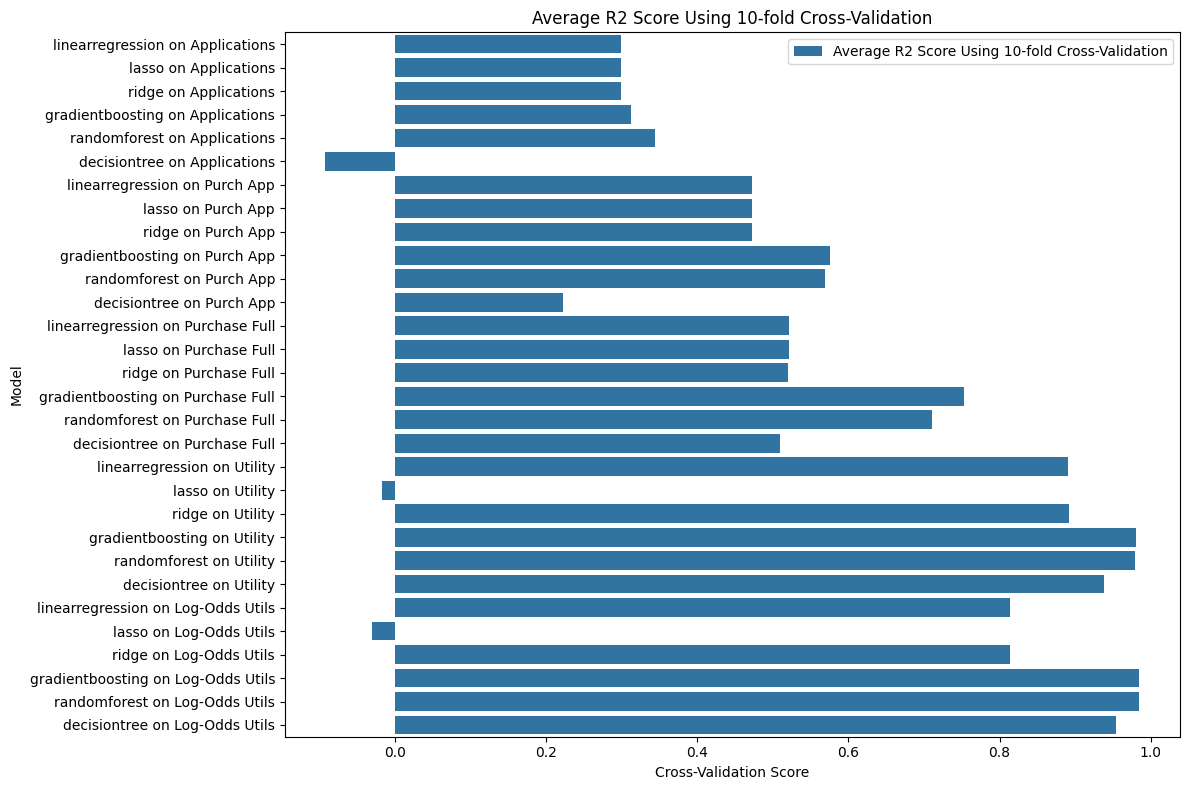

In [14]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_results['Cross-Validation Score'],y=df_results['Model'],label="Average R2 Score Using 10-fold Cross-Validation")
plt.title("Average R2 Score Using 10-fold Cross-Validation")
plt.legend()
plt.tight_layout()
plt.savefig("images/cross_val_scores.png")
plt.show()

In [15]:




linearregression_params = {
'copy_X': [True,False], 
'fit_intercept': [True,False], 
'n_jobs': [1000,5000,10000], 
'positive': [True,False]}



lasso_params = {
    'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }


ridge_params = {
    'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }




gradientboosting_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10]
    }

RandomForestRegressor().get_params(deep=True)
randomforest_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

decisiontreeregressor_params = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}




models = {
    "LinearRegression":(LinearRegression(),linearregression_params),
    "Lasso":(Lasso(),lasso_params),
    "ridge":(Ridge(),ridge_params),
    "randomforest":(RandomForestRegressor(),randomforest_params),
    "gradientboostingregressor":(GradientBoostingRegressor(),gradientboosting_params),
    "decisiontreeregreesor":(DecisionTreeRegressor(),decisiontreeregressor_params),

    }

best_scores = []

X_train,X_test,y_train,y_test = train_test_split(X3,y4,test_size=.20,random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
for model_name,(model,params) in models.items():
    model.fit(X_train_scaled,y_train)
    grid_search = GridSearchCV(model,params,scoring="neg_mean_squared_error",cv=4,n_jobs=-1)
    grid_search.fit(X_train_scaled,y_train)
    print(f'Best Params from GridSearch: {grid_search.best_params_}')
    print(f'Best Esitmator: {grid_search.best_estimator_}')
    print(f'Best Score: {grid_search.best_score_}')
    best_scores.append({"Model":model_name,"Best Score":grid_search.best_score_})
        
best_scores_df = pd.DataFrame(best_scores)
print(best_scores_df)



Best Params from GridSearch: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1000, 'positive': False}
Best Esitmator: LinearRegression(n_jobs=1000)
Best Score: -0.05312858842450861
Best Params from GridSearch: {'alpha': 0.01}
Best Esitmator: Lasso(alpha=0.01)
Best Score: -0.05196497452471734
Best Params from GridSearch: {'alpha': 1}
Best Esitmator: Ridge(alpha=1)
Best Score: -0.053067599400204966
Best Params from GridSearch: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Esitmator: RandomForestRegressor(max_depth=10, n_estimators=50)
Best Score: -0.006029073065398933
Best Params from GridSearch: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best Esitmator: GradientBoostingRegressor(n_estimators=200)
Best Score: -0.003748679055189926
Best Params from GridSearch: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Esitmator: DecisionTreeRegressor(max_depth=10, min_samples_split=5)
Best Sc